# Long-Short Term Memory Netze und Anwendungen

### 1. Wie LSTM's ein "Gedächtins" entwickeln


In [1]:
from IPython.display import Image

##### Feed Forward Neural Nets

* Nachbau der Struktur von Neuronen 
* "Kopplung von GLM's"

##### Recurrent Neural Networks

* "Füge Neuronalen Netzen einen Zwischenspeicher hinzu"
* Die Vorhersage setzt sich also aus einem "State" des Netzes und Inputdaten zusammen

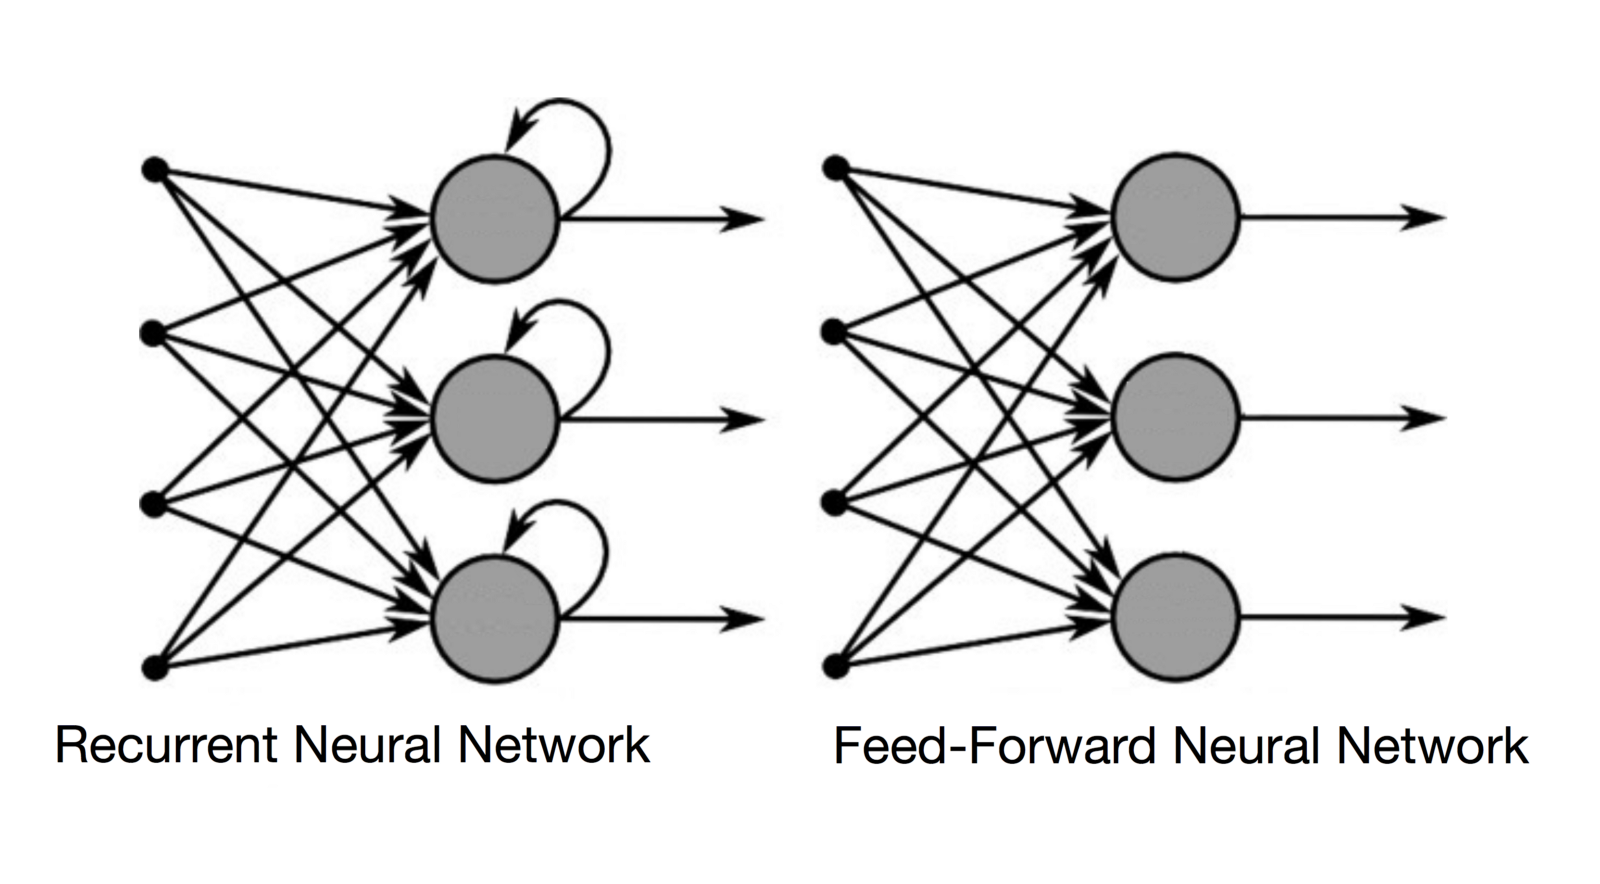

In [2]:
Image("./misc/recurrent_ffnet.png")

##### LSTM

* Erzeugen ein bestimmte Struktur der Rekurrenz, die insbesondere die letzte Schätzung zusammen mit einem "Hidden State" in die Prognose mit einbezieht
* Typische Anwendungen sind "Reinforcement Learning" und Zeitreihen
* Zusammensetzung mithilfe von sog. "Gates" die "lernen" sollen was relevant für die Prognose ist.

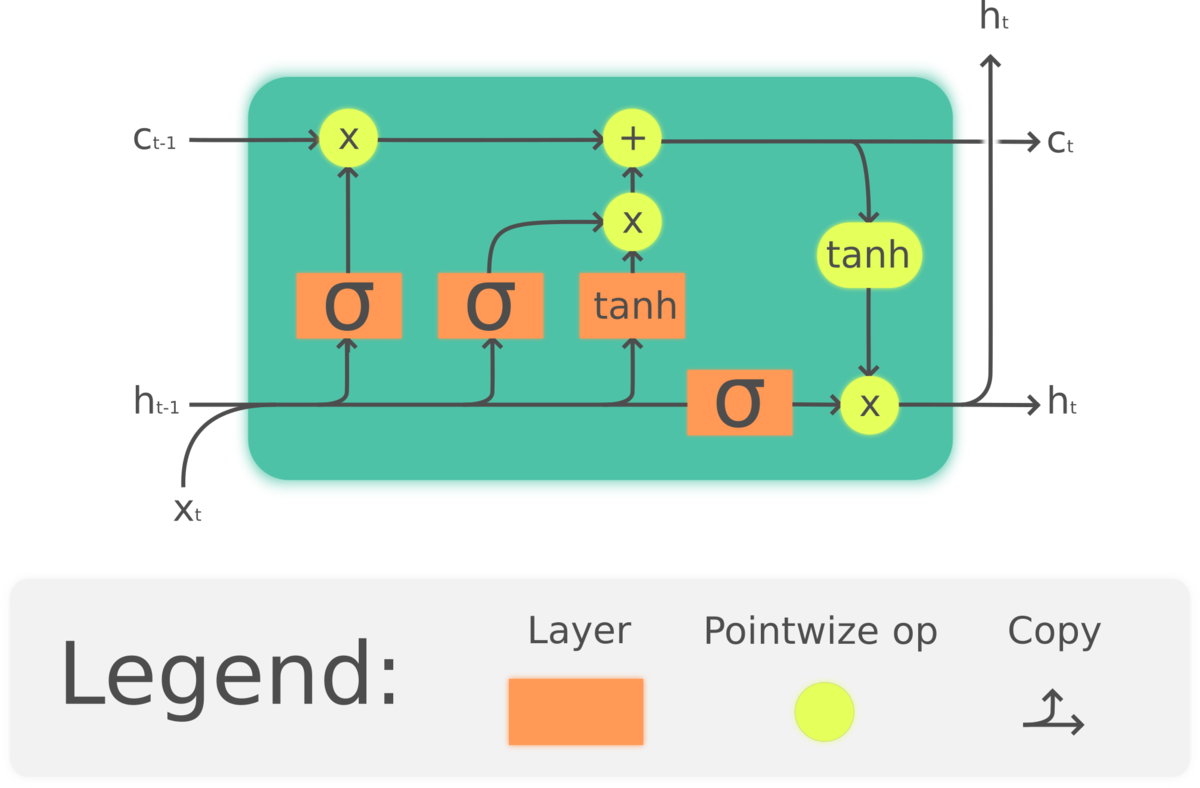

In [3]:
# Bildquelle: https://adhaamehab.me/2019/03/01/lstm-for-pos-tagging.html
Image("./misc/LSTM_cell.png")

Damit sind die Vorhersagen durch folgende Gleichungen gegeben, wobei $"*", \sigma(\cdot)$ und $tanh(\cdot)$ immer elementweise zu verstehen sind.

1. Gates: 

$
f_t = \sigma(W_{f,h} h_{t-1} + W_{f,x} x_t + b_f) \\
i_t = \sigma(W_{h,1} h_{t-1} + W_{i,1,x} x_t + b_{i,1}) * tanh(W_{h,2} h_{t-1} + W_{i,2,x} x_t + b_{i,2}) \\
o_t = \sigma(W_{o,h} h_{t-1} + W_{o,x} x_t + b_o)
$

2. Punktweise Multiplikation und Addition für Hidden State $c_t$ und Output $h_t$

$
c_t = c_{t-1} * f_t + i_t \\
h_t = tanh(c_t) * o_t
$

Zusammen also:

$
f_{LSTM} \colon \mathbb{R}^n \times \mathbb{R}^m \times \mathbb{R}^m \rightarrow \mathbb{R}^m \times \mathbb{R}^m, \quad (x, c, h) \mapsto f_{LSTM}(x,c,h) = \colon(c_{new}, h_{new})
$

__Bemerkung:__

Für die zu optimierenden Gewichte gilt:
$
W_{f,x}, W_{i,1,x}, W_{i,2,x}, W_{o,x} \in \mathbb{R}^{m \times n} \\
W_{f,h}, W_{h,1}, W_{h,2}, W_{o,h} \in \mathbb{R}^{m \times m}\\
b_f, b_{i,1}, b_{i,2}, b_o \in \mathbb{R}\\
$

Das zugehörige __Minimierungsproblem__ für eine "empirical loss function" $L_S$ auf dem Datensatz $S = ((x_1,y_1),...,(x_n,y_n))$ ist:

$\quad  min_{W_{f,h},..., b_o, S} \quad L_S(h_t, y_t)$

Unter bestimmten Anforderungen an die Daten S und an die loss function L lassen sich mittels nichtlinearer Optimierung und lokale Minima finden.

### Anwendung und Training auf einem Datensatz

Als Beispiel einen Zeitreihendatensatz von https://www.kaggle.com/jolasa/waves-measuring-buoys-data-mooloolaba/

Zum Datensatz:

* 6 Zeitreihen mit Messungen alle 30 Minuten im Zeitraum 01.01.2017 00:00 bis 30.06.2019 23:30
* Daten einer Messboje zu Wellen
* Messdaten sind:
        1. Hs: Significant wave height, an average of the highest third of the waves in a record
        2. Hmax: The maximum wave height in the record
        3. Tz: The zero upcrossing wave period (Dauer bis eine Welle vorbeigezogen ist)
        4. Tp: The peak energy wave period
        5. Peak Direction: Direction (related to true north) from which the peak period waves are coming from
        6. SST: Approximation of sea surface temperature
        
##### Fragestellung
1. Kann man den "Sea State" für den nächsten Messzeitpunkt mit einem LSTM vorhersagen und ist diese Vorhersage besser als den aktuellen Zustand als Schätzung für t + 30 Minuten zu verwenden ? (Bessere Vorhersage als VAR ?) 
2. Ist es möglich mit einem LSTM die zukünftige Entwicklung des Sea States zu Simulieren und ist die Simulation denn echten Daten "ähnlich" ?

In [4]:
import folium

folium.folium.Map(
    location = (-26.339, 153.108)
)

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import statsmodels.tsa as tsa

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image
import utils as u
from train.keras_lstm import get_lstm_model

In [6]:
df = pd.read_csv("./data/buoy_data.csv")
df.replace(-99.9, np.nan, inplace = True)
df.set_index("Date/Time", inplace = True)

In [7]:
df.describe()

,Hs,Hmax,Tz,Tp,Peak Direction,SST
count,43643.000000,43643.000000,43643.000000,43643.000000,43457.000000,43466.000000
mean,1.237735,2.090030,5.617440,9.006583,98.625653,23.949464
std,0.528257,0.897037,0.928361,2.391159,24.276846,2.231073
min,0.294000,0.510000,3.076000,2.720000,5.000000,19.800000
25%,0.840000,1.410000,4.977000,7.290000,85.000000,21.900000
50%,1.130000,1.900000,5.527000,8.884000,101.000000,23.950000
75%,1.543000,2.600000,6.164000,10.671000,116.000000,26.050000
max,4.257000,7.906000,10.921000,21.121000,358.000000,28.650000


##### Kurzfazit Daten

* NA's vorhanden, allerdings als Wert -99 Codiert, deshalb ausgenommen.

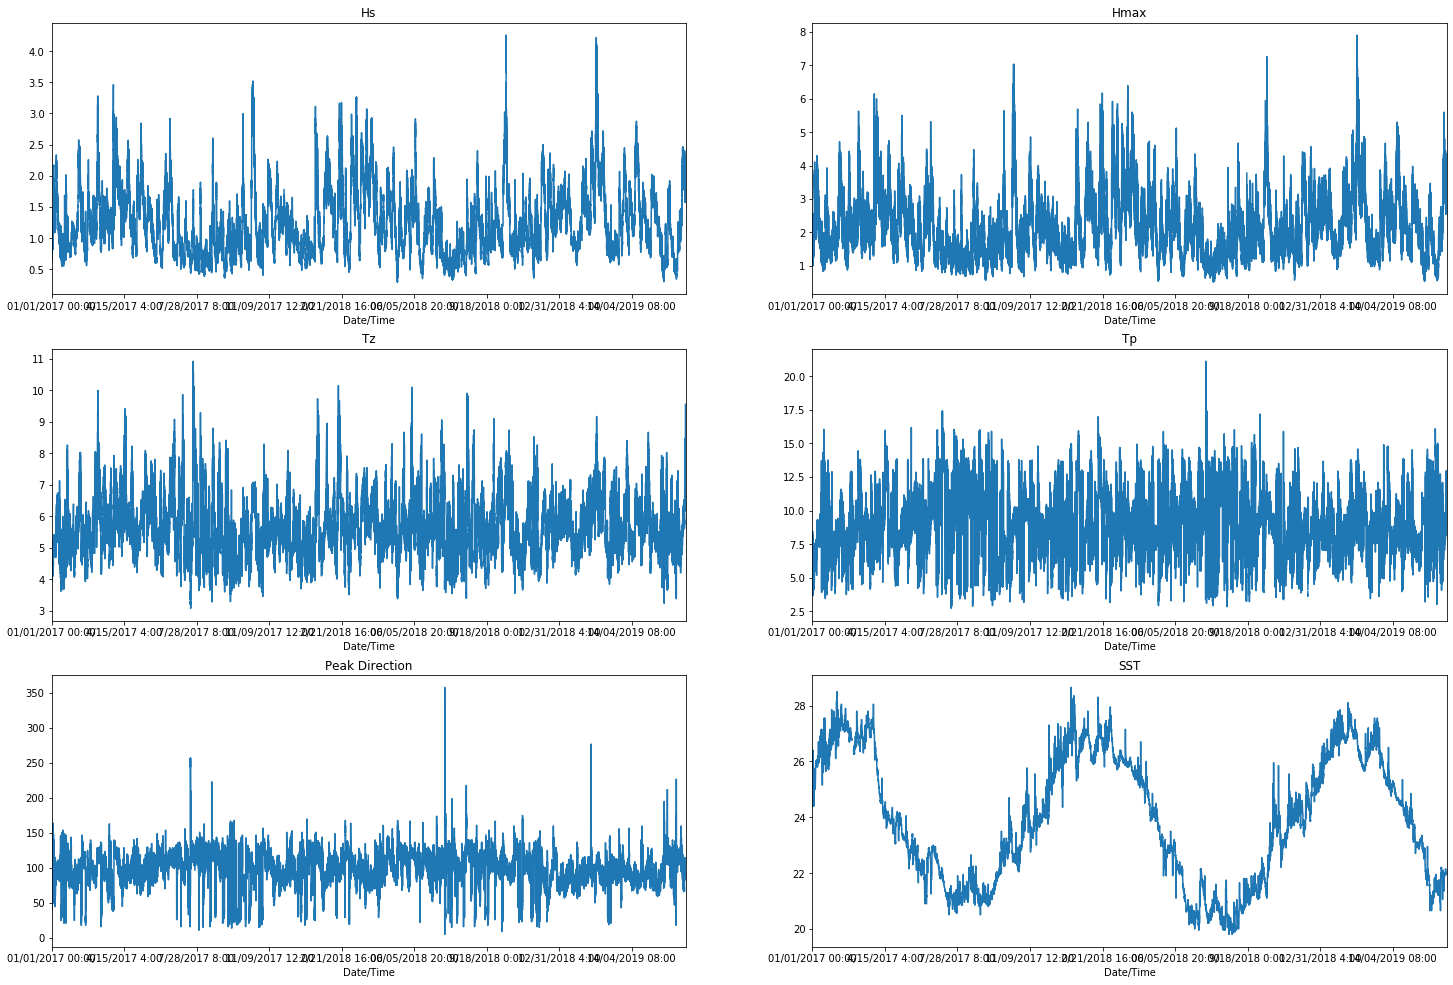

In [8]:
fig, ax = plt.subplots(3,2, figsize = (25,17))

df['Hs'].plot(ax = ax[0][0], title = "Hs")
df['Hmax'].plot(ax = ax[0][1], title = 'Hmax')
df['Tz'].plot(ax = ax[1][0], title = 'Tz')
df['Tp'].plot(ax = ax[1][1], title = 'Tp')
df['Peak Direction'].plot(ax = ax[2][0], title = 'Peak Direction')
df['SST'].plot(ax = ax[2][1], title = 'SST')

Ein Blick auf die Korrelationsstruktur der Zeitreihen hilft später bei der Modellierung des Fehlers:

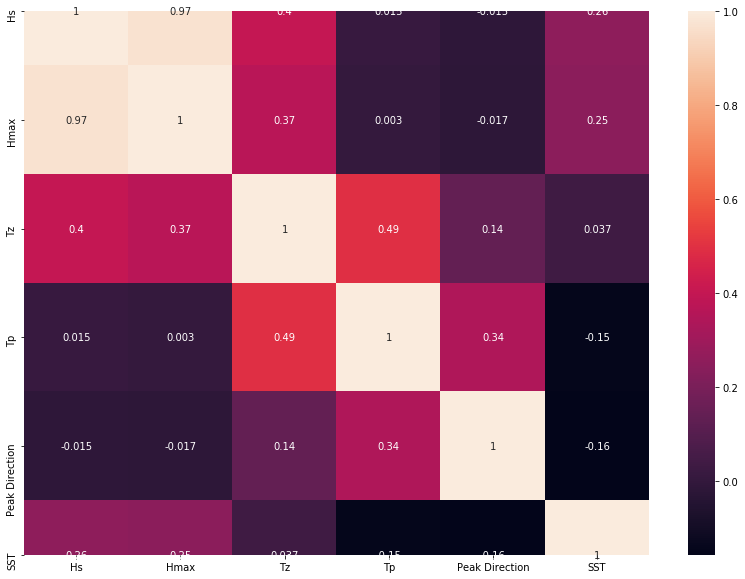

In [9]:
fig, ax = plt.subplots(figsize = (14,10))

sns.heatmap(df.corr(), annot=True, ax = ax)

Hier "sieht" man zu erwartende Zusammenhänge:

1. Hs und Hmax sind hoch korreliert, da Hs der durchschnitt des Höchsten drittels an Wellen und Hmax das Maximum
2. Dauer einer Wellenperiode und Energie hängen zusammen
3. Periodendauer hängt mit maximaler Wellenlänge zusammen

Der Rest ist (beinahe) unkorreliert auf den ersten Blick

### Data Cleaning

Um das auffüllen der NA's kurz zu halten wird hier per pandas Funktionalität ein Cubic Spline zum Auffüllen benutzt und ein kurzer Check per Auge auf numerische Fehler gemacht.

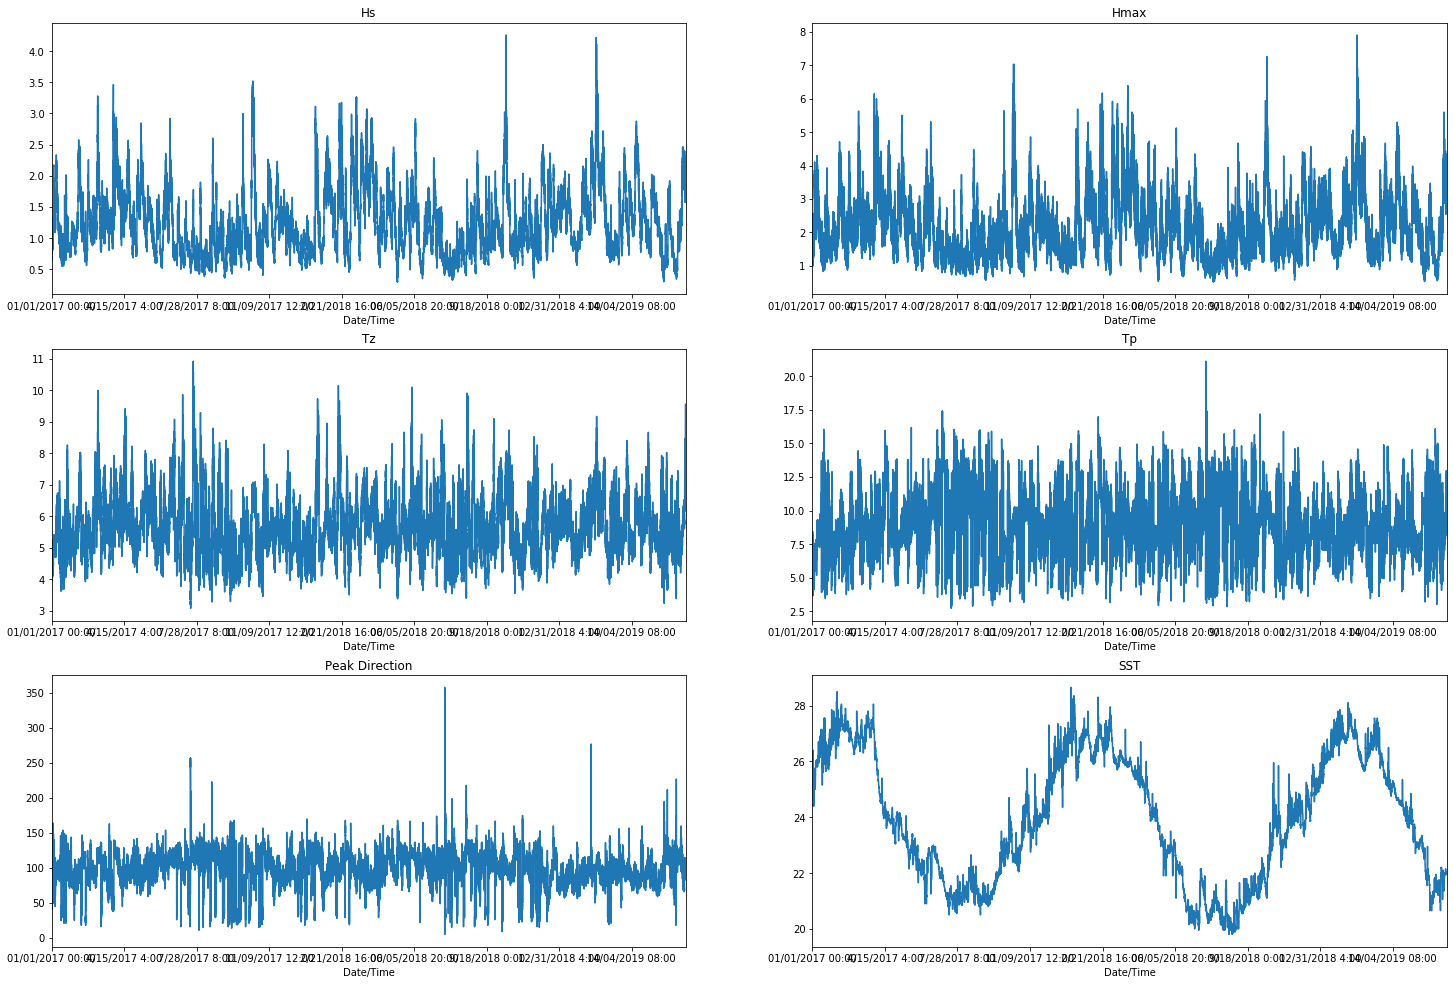

In [10]:
df_inter = df.copy(deep = True)
df_inter.interpolate(inplace = True)

fig, ax = plt.subplots(3,2, figsize = (25, 17))

df_inter['Hs'].plot(ax = ax[0][0], title = "Hs")
df_inter['Hmax'].plot(ax = ax[0][1], title = 'Hmax')
df_inter['Tz'].plot(ax = ax[1][0], title = 'Tz')
df_inter['Tp'].plot(ax = ax[1][1], title = 'Tp')
df_inter['Peak Direction'].plot(ax = ax[2][0], title = 'Peak Direction')
df_inter['SST'].plot(ax = ax[2][1], title = 'SST')

### Nichtparametrisches Modell mit LSTM zum approximieren der Zielfunktion

##### Kurzeinführung in tensorflow und tf.keras:

1. Tensorflow
    
    * C++ Paket für Rechnen mit Arrays
    * Aufrufbar von (fast) allen gängigen Programmiersprachen 

2. Keras
    
    * bereitstellen typischer Layers, Optimierer und loss functions von Tensorflow in aufgeräumter API für Python
    * Sehr Nutzerfreundlich und dank Tensorflow als "Workhorse" relativ schnell

##### Datenaufbereitung

In [11]:
df_train = df_inter.loc['01/01/2017 01:00':].copy(deep=True)

In [12]:
df_train[:-1]

,Hs,Hmax,Tz,Tp,Peak Direction,SST
Date/Time,,,,,,
01/01/2017 01:00,0.763,1.15,4.520,5.513,49.0,25.65
01/01/2017 01:30,0.770,1.41,4.582,5.647,75.0,25.50
01/01/2017 02:00,0.747,1.16,4.515,5.083,91.0,25.45
01/01/2017 02:30,0.718,1.61,4.614,6.181,68.0,25.45
01/01/2017 03:00,0.707,1.34,4.568,4.705,73.0,25.50
...,...,...,...,...,...,...
30/06/2019 21:00,2.174,3.30,9.557,12.875,94.0,21.95
30/06/2019 21:30,2.299,3.60,9.281,12.765,94.0,21.95
30/06/2019 22:00,2.075,3.04,9.303,12.722,95.0,21.95


In [13]:
df_train[1:]

,Hs,Hmax,Tz,Tp,Peak Direction,SST
Date/Time,,,,,,
01/01/2017 01:30,0.770,1.41,4.582,5.647,75.0,25.50
01/01/2017 02:00,0.747,1.16,4.515,5.083,91.0,25.45
01/01/2017 02:30,0.718,1.61,4.614,6.181,68.0,25.45
01/01/2017 03:00,0.707,1.34,4.568,4.705,73.0,25.50
01/01/2017 03:30,0.729,1.21,4.786,4.484,63.0,25.50
...,...,...,...,...,...,...
30/06/2019 21:30,2.299,3.60,9.281,12.765,94.0,21.95
30/06/2019 22:00,2.075,3.04,9.303,12.722,95.0,21.95
30/06/2019 22:30,2.157,3.43,9.168,12.890,97.0,21.95


In [14]:
x_train = df_train[:-1].values
y_train = df_train[1:].values

x_train = np.reshape(x_train, (-1,6,1))

Unter der Annahme, dass LSTM's tatsächlich jeden "lernbaren" kausalen Zusammenhang einer Zeitreihe lernen können (also den deterministischen Anteil + MA Prozess), erscheint folgende Modellannahme naheliegend:

$ \quad x_{t+1} = f(x_t) + \epsilon_{t+1} \quad t \in \mathbb{N}, \quad x_t, c_t, h_t \in \mathbb{R}^6, \quad \epsilon_t $ uiv Zufallsvektor mit Erwartungswert 0 und TODO KOVARIANZ

Der gewählte Schätzer für f ist der Output $h_{t+1}$ der LSTM Zelle:

$\quad \hat{f}(x_t) = f_{LSTM, h}(x_t, c_t, h_t)$

In [15]:
model = get_lstm_model()
model.load_weights("./models/lstm_Hs.h5")

MemoryError: Unable to allocate array with shape (43725, 43726) and data type float64

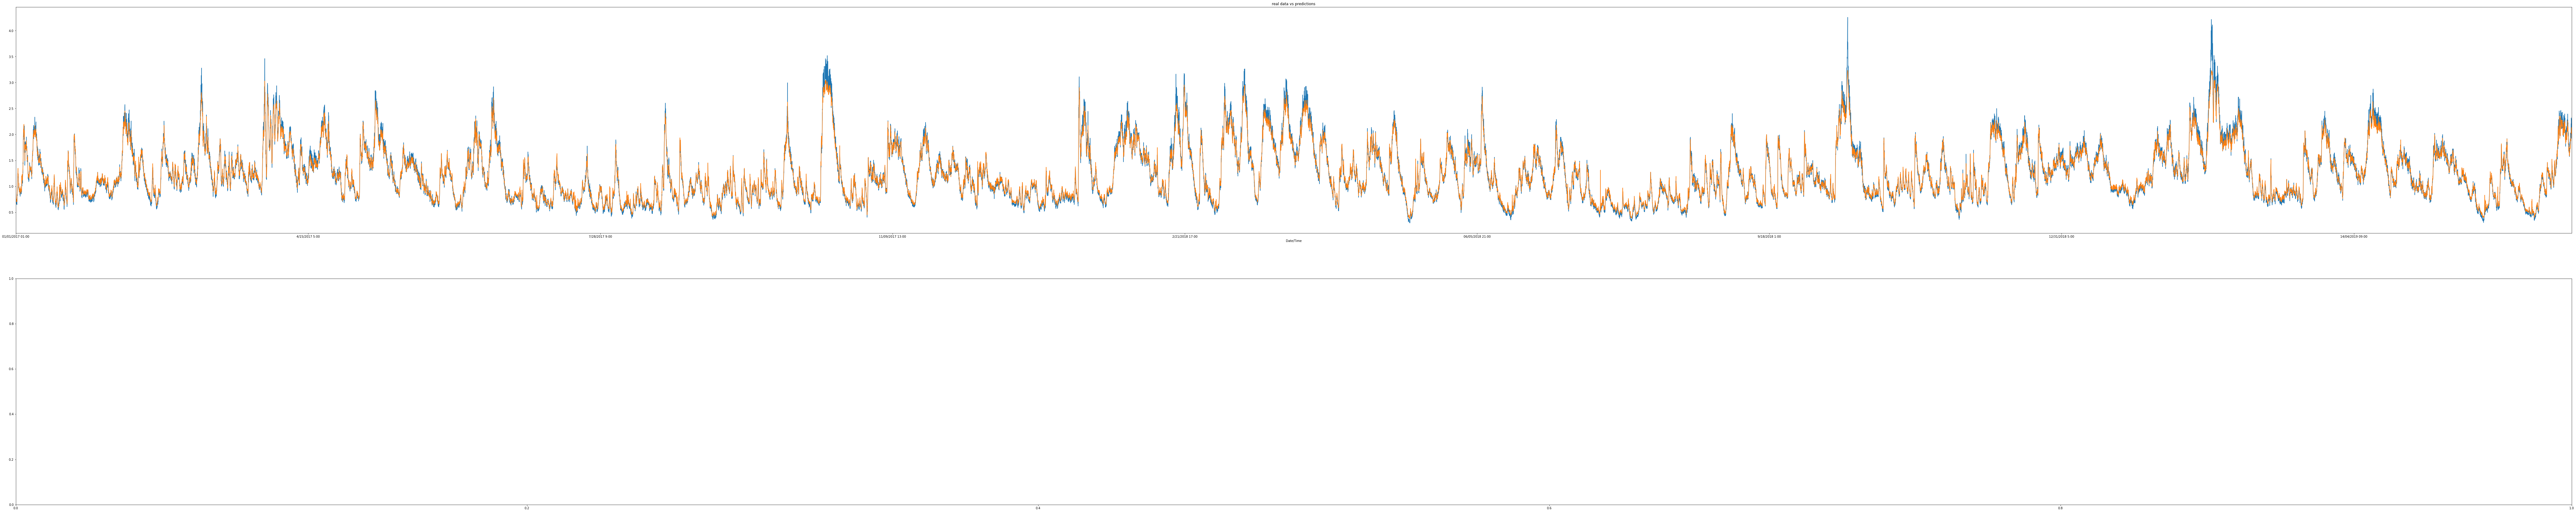

In [23]:
preds = model.predict(x_train)

fig, ax = plt.subplots(2, figsize=(150,30))

df_train['Hs'].plot(ax=ax[0], title = "real data vs predictions")
ax[0].plot(preds)

(df_train['Hs'].values - preds).plot(ax=ax[1], title="residuals")

I see a perfectly fine white noise

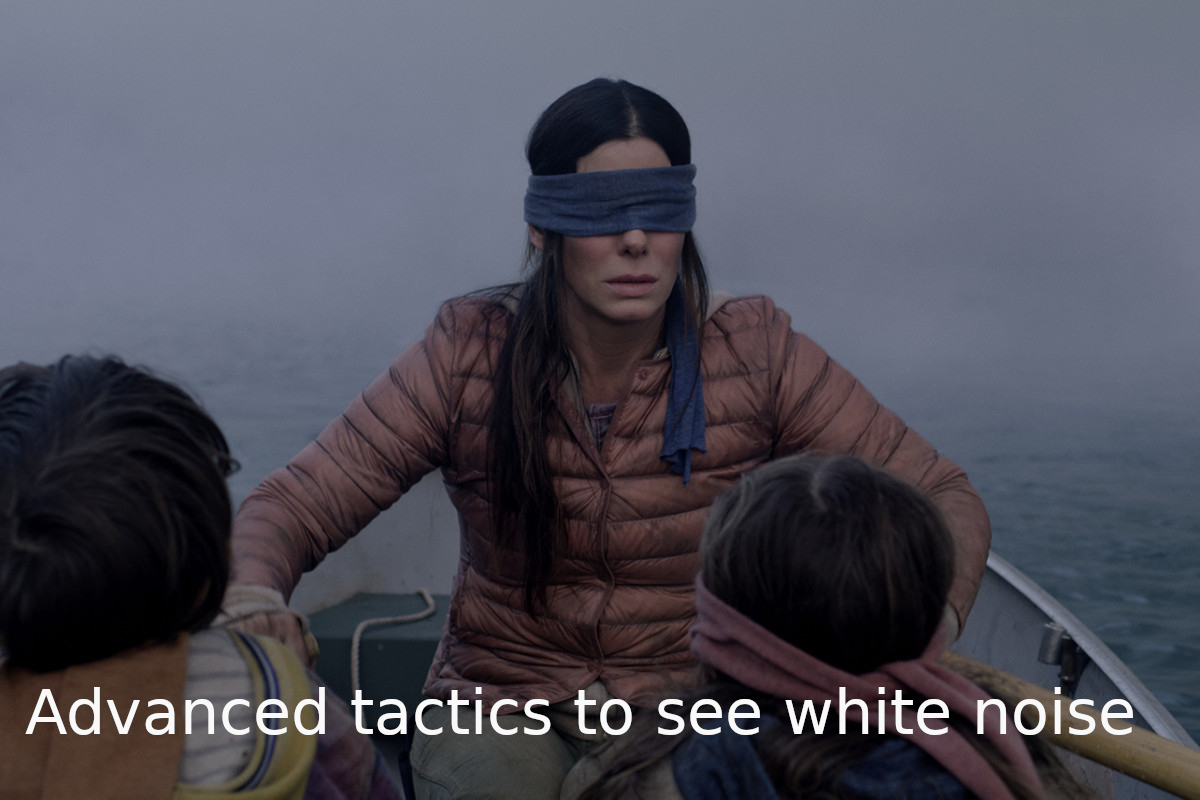

In [17]:
Image("./misc/Bird-Box-lead.jpg")

### Simulation mit dem Modell

Nach dem Modell und der erarbeitung des Fehlers in der Modellevaluation ... 

TODO

In [18]:
df.axes

[Index(['01/01/2017 00:00', '01/01/2017 00:30', '01/01/2017 01:00',
        '01/01/2017 01:30', '01/01/2017 02:00', '01/01/2017 02:30',
        '01/01/2017 03:00', '01/01/2017 03:30', '01/01/2017 04:00',
        '01/01/2017 04:30',
        ...
        '30/06/2019 19:00', '30/06/2019 19:30', '30/06/2019 20:00',
        '30/06/2019 20:30', '30/06/2019 21:00', '30/06/2019 21:30',
        '30/06/2019 22:00', '30/06/2019 22:30', '30/06/2019 23:00',
        '30/06/2019 23:30'],
       dtype='object', name='Date/Time', length=43728),
 Index(['Hs', 'Hmax', 'Tz', 'Tp', 'Peak Direction', 'SST'], dtype='object')]

### Recap

TODO

##### Danke für eure Aufmerksamkeit !